In [444]:
import os
import xarray as xr
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
import piecewise_regression
import pandas as pd
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import cartopy 
import cartopy.crs as ccrs
import seaborn as sns
sns.set(style='ticks',font_scale=2)

In [445]:
def ols(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan, np.nan

    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if (len(x)<20 or len(y)<20):
        return np.nan, np.nan
    if (y==y.max()).all() or (x==x.max()).all():
        return np.nan,np.nan
    mod = smapi.OLS(y,smapi.add_constant(x)).fit()
    return mod.params[1], mod.pvalues[1]


In [3]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [4]:
ims = xr.open_dataset(os.path.join(data_dir,'ims_24km','wy_sc.nc')).sel(time=slice("1998","2022")) # water years 1999-2023
era5 = xr.open_dataset(os.path.join(data_dir,'era5','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ims['sc'] = ims['sc'].clip(max=365)


sc_mask = (ims['sc'].median("time")>30)&(ims['sc'].median("time")<364) # mask out places with permanent snow or median of <30 days
ims = ims.where(sc_mask)
era5 = era5.where(sc_mask)
era5['tavg_clim'] = era5['tavg'].mean("time")

gridded_dsc_dt, gridded_dsc_dt_p = xr.apply_ufunc(ols,
                                                era5['tavg'],
                                                ims['sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
gridded_dsc_dt = 100*gridded_dsc_dt/ims['sc'].mean("time")
gridded_dsc_dt.name = 'dsc_dt'
gridded_dsc_dt_p.name = 'dsc_dt_p'
gridded_df = xr.merge([era5_ndjfm[['tavg_clim']],gridded_dsc_dt,gridded_dsc_dt_p]).to_dataframe().dropna()


In [187]:
ts = np.arange(-36,6,0.5)
gridded_sc_means = []
gridded_sc_stds = []
for t in ts:
    _coef = gridded_df[(gridded_df['tavg_clim']>t-2.5)&(gridded_df['tavg_clim']<=t+2.5)]['dsc_dt'] # rolling 5-degree temperature bin
    gridded_sc_means.append(_coef.mean())
    gridded_sc_stds.append(_coef.std())
    gridded_sc_frac.append((_coef<0).mean())
    gridded_sc_counts.append(len(_coef))
gridded_sc_means = np.array(gridded_sc_means)
gridded_sc_stds = np.array(gridded_sc_stds)

In [9]:
snotel_ds = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc'))
ecad_ds = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc'))
ghcnd_ds = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc'))
insitu_ds = xr.concat([snotel_ds,ecad_ds,ghcnd_ds],dim='site').sel(time=slice("1998","2022"))
insitu_ds = insitu_ds.where(insitu_ds['wy_sc'].median("time")>30,drop=True)
insitu_ds = insitu_ds.where((insitu_ds['wy_sc'].count("time")>=20)&(insitu_ds['tavg'].count("time")>=20),drop=True)
insitu_ds['tavg_clim'] = insitu_ds['tavg'].mean("time")

insitu_dsc_dt, insitu_dsc_dt_p = xr.apply_ufunc(ols,
                                                insitu_ds['tavg'],
                                                insitu_ds['wy_sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
insitu_dsc_dt = 100*insitu_dsc_dt/insitu_ds['wy_sc'].mean("time")
insitu_dsc_dt.name = 'dsc_dt'
insitu_dsc_dt_p.name = 'dsc_dt_p'

insitu_df = xr.merge([insitu_ds['tavg_clim'],
                      insitu_dsc_dt,insitu_dsc_dt_p,]).to_dataframe()


In [210]:
insitu_sc_means = []
insitu_sc_stds = []
for t in ts:
    _coef = insitu_df[(insitu_df['tavg_clim']>t-2.5)&(insitu_df['tavg_clim']<=t+2.5)]['dsc_dt']
    insitu_sc_means.append(_coef.mean())
    insitu_sc_stds.append(_coef.std())
insitu_sc_means = np.array(insitu_sc_means)
insitu_sc_stds = np.array(insitu_sc_stds)


In [443]:
gridded_mod=piecewise_regression.Fit(ts,np.gradient(gridded_sc_means),n_breakpoints=2)
insitu_mod=piecewise_regression.Fit(ts,np.gradient(insitu_sc_means),n_breakpoints=2)


In [474]:
bp_mean = gridded_mod.get_results()['estimates']['breakpoint1']['estimate']
bp_ci = gridded_mod.get_results()['estimates']['breakpoint1']['confidence_interval']

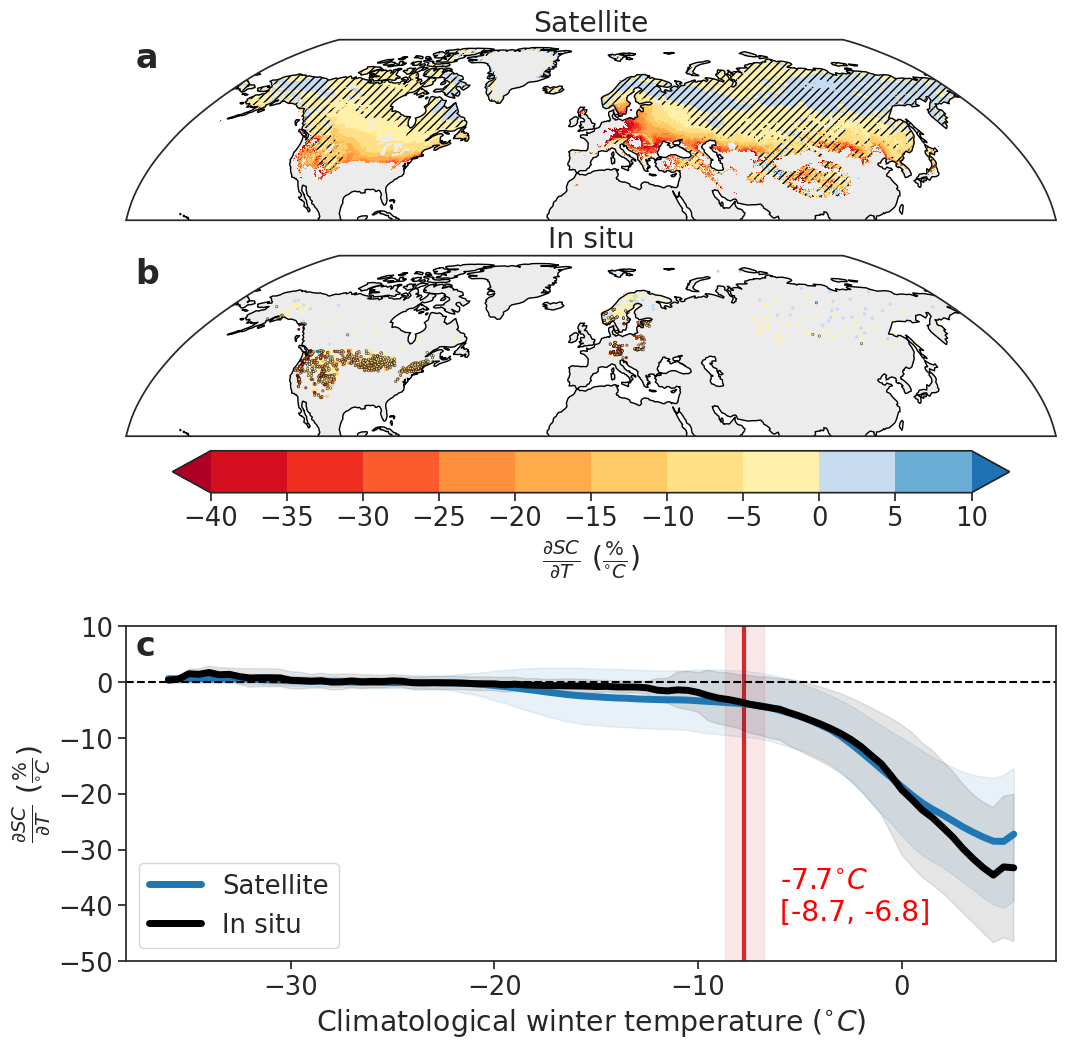

In [477]:


sns.set(style='ticks',font_scale=1.7)
cols = np.concatenate([sns.color_palette("YlOrRd_r",9),sns.color_palette("Blues",3)])
cmap= mpl.colors.ListedColormap(cols[1:-1])
cmap.set_under(cols[0])
cmap.set_over(cols[-1])
norm = plt.Normalize(vmin=-40,vmax=10)

unc_cols = sns.color_palette("YlOrRd",8)
unc_cmap = mpl.colors.ListedColormap(unc_cols[:-1])
unc_cmap.set_over(unc_cols[-1])
unc_norm = plt.Normalize(vmin=0,vmax=70)

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=4,ncols=1,height_ratios=[1,1,0.1,1.5],figure=fig)

ax1 = plt.subplot(gs[0],projection=ccrs.Robinson())
ax2 = plt.subplot(gs[1],projection=ccrs.Robinson())
ax3 = plt.subplot(gs[3])

gridded_dsc_dt.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
cs = gridded_dsc_dt_p.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(),levels=[0,0.01,1],colors='none',hatches=[None,'////'],edgecolor='black',add_colorbar=False)
for c in cs.collections:
    c.set_edgecolor("black")
    c.set_linewidth(0.)
ax1.title.set_text("Satellite")

insitu_df[insitu_df['dsc_dt_p']>0.01].plot.scatter(ax=ax2,x='lon',y='lat',c='dsc_dt',transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,s=2,colorbar=False)
insitu_df[insitu_df['dsc_dt_p']<=0.01].plot.scatter(ax=ax2,x='lon',y='lat',c='dsc_dt',transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,s=3,edgecolor='black',lw=0.3,colorbar=False)
ax2.title.set_text("In situ")


ax3.plot(ts,gridded_sc_means,color='tab:blue',lw=5,label='Satellite')
ax3.fill_between(ts,gridded_sc_means-gridded_sc_stds,gridded_sc_means+gridded_sc_stds,color='tab:blue',alpha=0.1,)
ax3.set_ylabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)',)
ax3.plot(ts,insitu_sc_means,color='black',lw=5,label='In situ')
ax3.fill_between(ts,insitu_sc_means-insitu_sc_stds,insitu_sc_means+insitu_sc_stds,color='black',alpha=0.1)
ax3.axvline(bp_mean,color='tab:red',lw=3,zorder=0)
ax3.axvspan(*bp_ci,color='tab:red',alpha=0.1)
ax3.text(-6,-33,f"{np.round(bp_mean,1)}"+"$^{\circ}C$\n"+f"[{np.round(bp_ci[0],1)}, {np.round(bp_ci[1],1)}]",ha='left',va='top',color='red')
ax3.legend()
ax3.set_ylim(-50,10)

ax3.axhline(0,color='black',linestyle='--')
ax3.set_xlabel("Climatological winter temperature ($^{\circ}C$)")


sm = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm,ax=[ax1,ax2],orientation='horizontal',drawedges=False,ticks=np.arange(-40,11,5),extend='both',pad=0.03,shrink=0.9)
cbar.ax.set_xlabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)')



for ax in [ax1,ax2]:
    ax.coastlines("110m")
    ax.set_extent([-180,180,20,90],ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
    
labels = ['a','b','c','d','e']
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.01,0.99,labels[i],ha='left',va='top',fontweight='bold',fontsize=24,transform=ax.transAxes)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','png','sc_nonlinearity.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','main','pdf','sc_nonlinearity.pdf'),bbox_inches='tight',dpi=350)


In [ ]:
# test varying bin widths

ts = np.arange(-36,6,0.5)

# 1 degree
gridded_sc_means_1deg = []
for t in ts:
    _coef = gridded_df[(gridded_df['tavg_clim']>t-0.5)&(gridded_df['tavg_clim']<=t+0.5)]['dsc_dt']
    gridded_sc_means_1deg.append(_coef.mean())
gridded_sc_means_1deg = np.array(gridded_sc_means_1deg)

# 2 degrees
gridded_sc_means_2deg = []
for t in ts:
    _coef = gridded_df[(gridded_df['tavg_clim']>t-1)&(gridded_df['tavg_clim']<=t+1)]['dsc_dt']
    gridded_sc_means_2deg.append(_coef.mean())
gridded_sc_means_2deg = np.array(gridded_sc_means_2deg)

# 5 degrees
gridded_sc_means_5deg = []
for t in ts:
    _coef = gridded_df[(gridded_df['tavg_clim']>t-2.5)&(gridded_df['tavg_clim']<=t+2.5)]['dsc_dt']
    gridded_sc_means_5deg.append(_coef.mean())
gridded_sc_means_5deg = np.array(gridded_sc_means_5deg)

# 10 degrees
gridded_sc_means_10deg = []
for t in ts:
    _coef = gridded_df[(gridded_df['tavg_clim']>t-5)&(gridded_df['tavg_clim']<=t+5)]['dsc_dt']
    gridded_sc_means_10deg.append(_coef.mean())
gridded_sc_means_10deg = np.array(gridded_sc_means_10deg)

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
ax.plot(ts,gridded_sc_means_1deg,lw=5,label='$1^{\circ}C$')
ax.plot(ts,gridded_sc_means_2deg,lw=5,label='$2^{\circ}C$')
ax.plot(ts,gridded_sc_means_5deg,lw=5,label='$5^{\circ}C$')
ax.plot(ts,gridded_sc_means_10deg,lw=5,label='$10^{\circ}C$')
ax.axhline(0,color='black',linestyle='--')
ax.legend(loc='lower left',title='Window width')
ax.set_ylabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)',)
ax.set_xlabel("Climatological winter temperature ($^{\circ}C$)")
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','png','window_width.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','pdf','window_width.pdf'),bbox_inches='tight',dpi=350)
